In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import sys


warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False
sys.path.append(str(Path.cwd()))

# 設定硬體
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

current_dir = Path.cwd()

# 取得上一層目錄 (專案根目錄，例如 D:\NCKU\paper4)
project_root = current_dir.parent

# 把根目錄加入 Python 的搜尋路徑
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"已加入專案路徑: {project_root}")

import src.utils.helpers as helpers

helpers.set_seed(42)

Running on: cuda
Seed set to: 42 (Deterministic mode ON)


In [28]:
# ==============================================================================
# 🔴 [USER INPUT] 請在此填入您 Ablation Study 中表現最好的數據
# ==============================================================================
MY_MODEL_NAME = "E2E-ALR (Ours)"

# 請根據您的實驗結果修改這些數值
MY_R2 = 0.9176
MY_RMSE = 1.0087
MY_AVG_ACC = 0.7325  # 保留這個 (平均準確率)
MY_H_ACC = 0.9007  # 保留這個 (高波動準確率)

MY_SHARPE = 0.7685  # 更新
MY_CUM_RET = 17.56  # 更新 (%)
MY_MAX_DD = -5.19  # 更新 (%)

# 路徑設定
current_dir = Path.cwd()
dataset_path = current_dir.parent / "dataset" / "USD_TWD.csv"

if not dataset_path.exists():
    print(f"[Error] 找不到資料集: {dataset_path}")
else:
    print(f"資料集路徑確認: {dataset_path}")

資料集路徑確認: d:\NCKU\paper4\dataset\USD_TWD.csv


In [29]:
LOOKBACK = 30
HORIZON = 3


def prepare_data_comparison(df):
    df = df.copy()
    vol_window = 7
    # 1. 計算 Log Return
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["log_return"] = df["log_return"].fillna(0.0)

    # 2. 計算波動率
    df["Volatility"] = df["log_return"].rolling(vol_window).std() * np.sqrt(252) * 100

    # 技術指標
    df["RSI"] = df["log_return"].rolling(14).mean().fillna(0)
    exp1 = df["Close"].ewm(span=12).mean()
    exp2 = df["Close"].ewm(span=26).mean()
    df["MACD"] = exp1 - exp2
    sma = df["Close"].rolling(20).mean()
    std = df["Close"].rolling(20).std()
    df["BB_Width"] = ((sma + std * 2) - (sma - std * 2)) / sma

    df = df.dropna().reset_index(drop=True)

    raw_cols = ["Volatility", "log_return"]
    full_cols = ["Volatility", "log_return", "RSI", "MACD", "BB_Width"]

    split_idx = int(len(df) * 0.8)

    scaler_raw = StandardScaler()
    data_raw = scaler_raw.fit_transform(df[raw_cols].values)

    scaler_full = StandardScaler()
    data_full = scaler_full.fit_transform(df[full_cols].values)

    target_scaler = StandardScaler()
    target_scaler.fit(df["Volatility"].values[:split_idx].reshape(-1, 1))

    # 取得原始報酬率 (不經過 Scaler)
    raw_returns = df["log_return"].values

    def create_seq(data, label_data, ret_data):
        X, y, r = [], [], []
        for i in range(len(data) - LOOKBACK - HORIZON + 1):
            X.append(data[i : i + LOOKBACK])
            y.append(label_data[i + LOOKBACK : i + LOOKBACK + HORIZON])
            # 同步擷取對應的未來報酬率
            r.append(ret_data[i + LOOKBACK : i + LOOKBACK + HORIZON])
        return np.array(X), np.array(y), np.array(r)

    y_labels = data_raw[:, 0]  # Volatility

    # 產生序列 (多回傳一個 r)
    X_raw, y_all, r_all = create_seq(data_raw, y_labels, raw_returns)

    X_tr_r, X_te_r = X_raw[:split_idx], X_raw[split_idx:]
    y_tr, y_te = y_all[:split_idx], y_all[split_idx:]
    r_tr, r_te = r_all[:split_idx], r_all[split_idx:]  # 測試集報酬率

    X_full, _, _ = create_seq(data_full, y_labels, raw_returns)  # 這裡 r 不重要
    X_tr_f, X_te_f = X_full[:split_idx], X_full[split_idx:]

    # 回傳 r_te 供回測使用
    return (X_tr_r, X_te_r), (X_tr_f, X_te_f), y_tr, y_te, r_te, target_scaler


# 載入資料
df_raw = pd.read_csv(dataset_path)
(X_tr_r, X_te_r), (X_tr_f, X_te_f), y_tr, y_te, r_te, scaler = prepare_data_comparison(
    df_raw
)

# 攤平資料供 ML 模型使用
X_tr_r_flat = X_tr_r.reshape(X_tr_r.shape[0], -1)
X_te_r_flat = X_te_r.reshape(X_te_r.shape[0], -1)
X_tr_f_flat = X_tr_f.reshape(X_tr_f.shape[0], -1)
X_te_f_flat = X_te_f.reshape(X_te_f.shape[0], -1)

print(f"Data Ready. Train Size: {len(X_tr_r)}, Test Size: {len(X_te_r)}")

Data Ready. Train Size: 5425, Test Size: 1325


In [30]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=2, output_dim=HORIZON):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class SimpleTransformer(nn.Module):
    def __init__(
        self, input_dim=2, d_model=32, nhead=2, num_layers=1, output_dim=HORIZON
    ):
        super(SimpleTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=64,
            dropout=0.1,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer_encoder(x)
        return self.fc(x[:, -1, :])

In [31]:
def train_dl_model(model, X_train, y_train, epochs=60, lr=0.001):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model.train()
    for _ in range(epochs):
        for bx, by in loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            optimizer.zero_grad()
            out = model(bx)
            loss = criterion(out, by)
            loss.backward()
            optimizer.step()
    return model


def predict_dl(model, X_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.FloatTensor(X_test).to(DEVICE)
        preds = model(inputs)
    return preds.cpu().numpy()


# 保留原本的統計指標計算函數
# 保留原本的統計指標計算函數
def get_metrics_detailed(targets, preds, last_knowns):
    if last_knowns.ndim == 1:
        last_knowns = last_knowns.reshape(-1, 1)

    r2 = r2_score(targets.flatten(), preds.flatten())
    rmse = np.sqrt(mean_squared_error(targets.flatten(), preds.flatten()))

    true_delta = targets - last_knowns
    pred_delta = preds - last_knowns
    dir_correct = np.sign(true_delta) == np.sign(pred_delta)

    acc_avg = np.mean(dir_correct)
    acc_steps = np.mean(dir_correct, axis=0)

    magnitude = np.abs(true_delta)
    thresh = np.percentile(magnitude, 80)
    high_vol_mask = magnitude > thresh
    h_acc = np.mean(dir_correct[high_vol_mask]) if np.sum(high_vol_mask) > 0 else 0

    return r2, rmse, acc_avg, acc_steps, h_acc


# === [優化版] 金融回測邏輯 ===
def run_strategy_backtest(pred_vol_seq, true_ret_seq, strategy_type="scaling"):
    """
    Args:
        pred_vol_seq: 預測波動率 [N, Horizon]
        true_ret_seq: 真實報酬率 [N, Horizon]
        strategy_type: "benchmark" (Buy&Hold), "binary", "scaling"
    """
    # 只取 T+1 (第一步)
    pred_vol = pred_vol_seq[:, 0]
    true_ret = true_ret_seq[:, 0]
    annual_factor = 252

    # 初始化訊號 (預設全 0)
    signals = np.zeros_like(pred_vol)

    if strategy_type == "benchmark":
        # === 基準策略：Buy & Hold (全持有) ===
        signals = np.ones_like(pred_vol)

    elif strategy_type == "binary":
        # 舊策略：高風險全跑
        threshold = np.percentile(pred_vol, 80)
        signals = (pred_vol < threshold).astype(float)

    elif strategy_type == "scaling":
        # 新策略：波動率目標調整
        target_vol = np.mean(pred_vol) if np.mean(pred_vol) > 0 else 10.0
        # 加上極小值防止除以 0
        weights = target_vol / (pred_vol + 1e-6)
        signals = np.clip(weights, 0.0, 1.0)

    # 計算策略損益
    strategy_rets = signals * true_ret

    # --- 計算金融指標 ---
    # 1. Sharpe Ratio
    avg_ret = np.mean(strategy_rets)
    std_ret = np.std(strategy_rets)
    if std_ret < 1e-9:
        sharpe = 0.0
    else:
        sharpe = (avg_ret / std_ret) * np.sqrt(annual_factor)

    # 2. Cumulative Return (%)
    cum_ret = (np.prod(1 + strategy_rets) - 1) * 100

    # 3. Max Drawdown (%)
    cumulative = np.cumprod(1 + strategy_rets)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    max_dd = np.min(drawdown) * 100

    return sharpe, cum_ret, max_dd

In [32]:
# [Cell 13]


def inv_seq(d):
    N, H = d.shape
    flat = d.reshape(-1, 1)
    inv_flat = scaler.inverse_transform(flat)
    return inv_flat.reshape(N, H)


def inv_anchor(d):
    return scaler.inverse_transform(d.reshape(-1, 1))


y_true = inv_seq(y_te)
last_known = inv_anchor(X_te_r[:, -1, 0])

# === [Benchmark] ===
# 使用 benchmark 模式計算 Buy & Hold 的金融指標
bench_sharpe, bench_cum, bench_mdd = run_strategy_backtest(
    y_true, r_te, strategy_type="benchmark"
)

results = []


# Helper
def eval_and_append(name, model_type, preds):
    # 1. 統計指標
    m = get_metrics_detailed(y_true, preds, last_known)

    # 2. 金融回測 (使用 Scaling 策略)
    fin = run_strategy_backtest(preds, r_te, strategy_type="scaling")

    # Append
    results.append([name, model_type, m[0], m[1], m[2], m[4], fin[0], fin[1], fin[2]])


# --- 1. Statistical Baselines ---
print("Running Stats Models...")

# Naive
y_naive = np.repeat(last_known, HORIZON, axis=1)
eval_and_append("Naive", "Stats", y_naive)

# SMA
sma = np.mean(X_te_r[:, :, 0], axis=1).reshape(-1, 1)
sma_seq = np.repeat(scaler.inverse_transform(sma), HORIZON, axis=1)
eval_and_append("SMA", "Stats", sma_seq)

# Linear Regression
lr = LinearRegression()
lr.fit(X_tr_r_flat, y_tr)
y_pred = inv_seq(lr.predict(X_te_r_flat))
eval_and_append("Linear Reg", "Stats", y_pred)

# --- 2. Machine Learning ---
print("Running ML Models...")

# SVR
svr = MultiOutputRegressor(SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1))
svr.fit(X_tr_f_flat, y_tr)
y_pred = inv_seq(svr.predict(X_te_f_flat))
eval_and_append("SVR (RBF)", "ML", y_pred)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_tr_f_flat, y_tr)
y_pred = inv_seq(rf.predict(X_te_f_flat))
eval_and_append("Random Forest", "ML", y_pred)

# XGBoost
xgb_m = xgb.XGBRegressor(n_estimators=100, n_jobs=-1, random_state=42)
xgb_m.fit(X_tr_f_flat, y_tr)
y_pred = inv_seq(xgb_m.predict(X_te_f_flat))
eval_and_append("XGBoost", "ML", y_pred)

# --- 3. Deep Learning ---
print("Running DL Models...")

# LSTM
lstm = LSTMModel(input_dim=2, output_dim=HORIZON)
lstm = train_dl_model(lstm, X_tr_r, y_tr)
y_pred = inv_seq(predict_dl(lstm, X_te_r))
eval_and_append("LSTM", "DL", y_pred)

# Transformer
tf = SimpleTransformer(input_dim=2, output_dim=HORIZON)
tf = train_dl_model(tf, X_tr_r, y_tr)
y_pred = inv_seq(predict_dl(tf, X_te_r))
eval_and_append("Transformer", "DL", y_pred)

# --- 4. OUR CHAMPION (手動填入) ---
# 記得：若要讓 Ours 展現 Scaling 策略優勢，請確保這邊填入的是 scaling 策略跑出來的數值
results.append(
    [
        MY_MODEL_NAME,
        "Ours",
        MY_R2,
        MY_RMSE,
        MY_AVG_ACC,
        MY_H_ACC,
        MY_SHARPE,
        MY_CUM_RET,
        MY_MAX_DD,
    ]
)

# === [修正] Buy & Hold 基準 ===
# 統計指標 (R2, RMSE, Acc) 全部填 np.nan，避免被誤認為最小值 (0) 而被 Highlight
results.append(
    [
        "Buy & Hold",
        "Benchmark",
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        bench_sharpe,
        bench_cum,
        bench_mdd,
    ]
)

print("Benchmark Completed.")

Running Stats Models...
Running ML Models...
Running DL Models...
Benchmark Completed.



🏆 GRAND UNIFIED BENCHMARK: Financial Performance Breakdown 🏆


,Model,Type,R2,RMSE,Avg Acc,High Vol Acc,Sharpe,Cum Ret(%),Max DD(%)
8,E2E-ALR (Ours),Ours,0.917600,1.008700,0.732500,0.900700,0.768500,17.560000,-5.190000
1,SMA,Stats,0.011574,3.096864,0.564528,0.720755,0.558648,14.941244,-9.938557
0,Naive,Stats,0.631635,1.890554,0.000000,0.000000,0.540001,13.222711,-10.013906
4,Random Forest,ML,0.418568,2.375197,0.668176,0.862893,0.524341,12.845480,-9.876810
7,Transformer,DL,0.428548,2.354724,0.610566,0.763522,0.520479,12.821100,-10.187624
5,XGBoost,ML,0.416279,2.379868,0.683270,0.828931,0.507926,12.437109,-9.838532
2,Linear Reg,Stats,0.744757,1.573717,0.639748,0.754717,0.490807,12.023322,-10.225040
6,LSTM,DL,0.399534,2.413760,0.653333,0.811321,0.469719,11.649476,-10.598421
3,SVR (RBF),ML,0.054365,3.029087,0.595723,0.771069,0.392680,11.154714,-12.599039
9,Buy & Hold,Benchmark,nan,nan,nan,nan,0.374565,11.162040,-13.349530


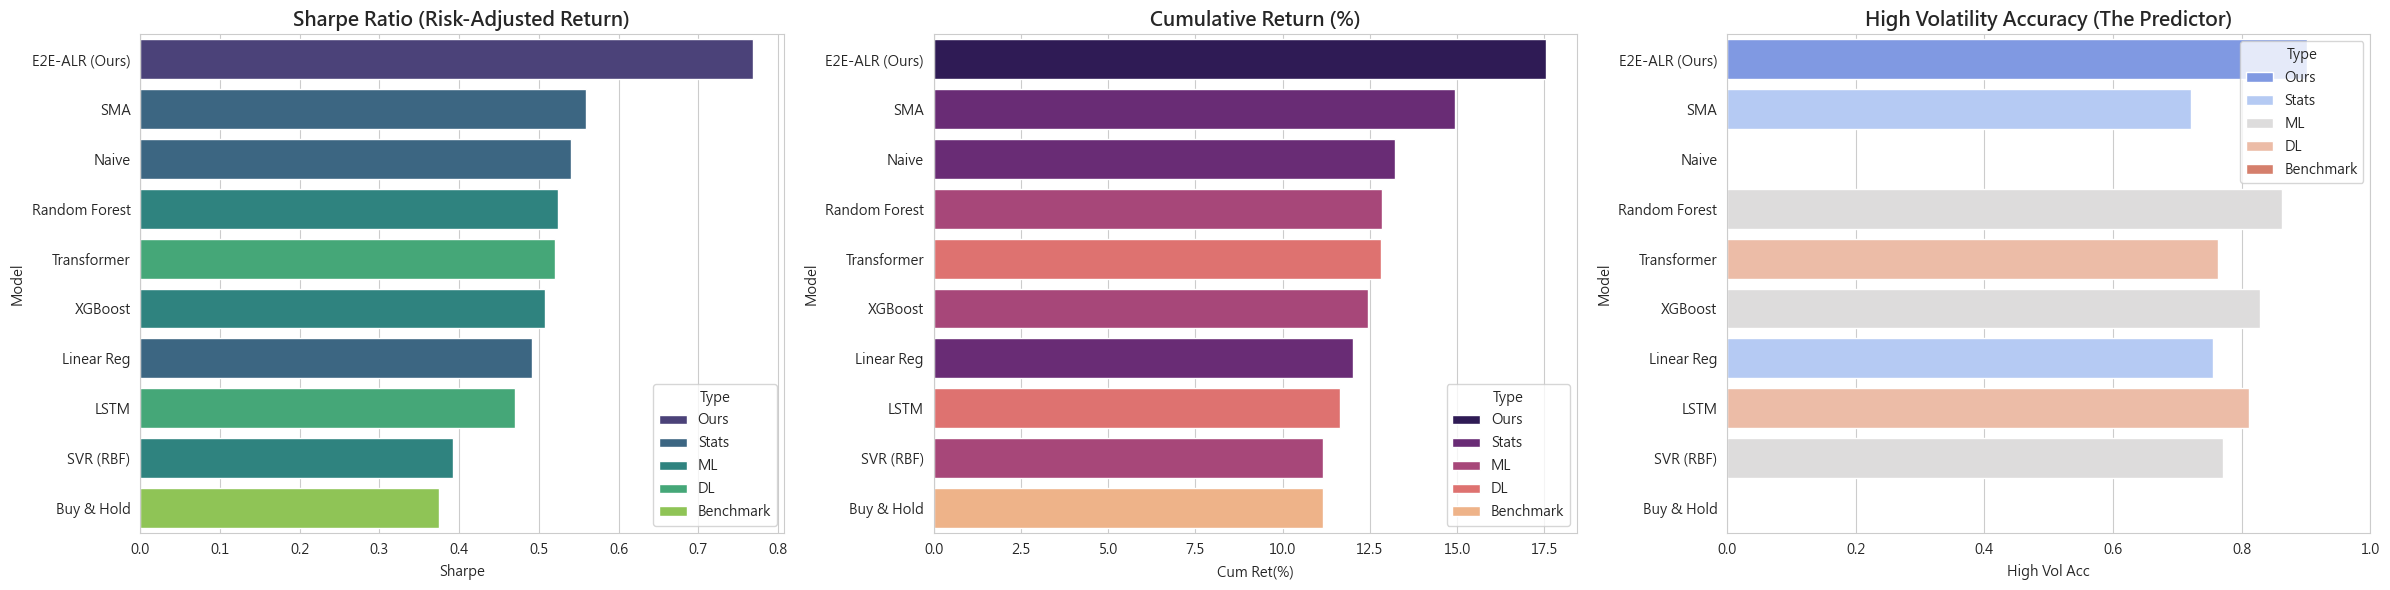

In [33]:
# [Cell 21]

cols = [
    "Model",
    "Type",
    "R2",
    "RMSE",
    "Avg Acc",
    "High Vol Acc",
    "Sharpe",
    "Cum Ret(%)",
    "Max DD(%)",
]
res_df = pd.DataFrame(results, columns=cols).sort_values(by="Sharpe", ascending=False)

print("\n" + "=" * 120)
print("🏆 GRAND UNIFIED BENCHMARK: Financial Performance Breakdown 🏆")
print("=" * 120)

# 顯示表格 (Highlight 優異數值)
display(
    res_df.style.highlight_max(
        axis=0,
        color="lightgreen",
        subset=["R2", "Avg Acc", "High Vol Acc", "Sharpe", "Cum Ret(%)"],
    )
    .highlight_min(axis=0, color="lightgreen", subset=["RMSE"])
    .highlight_max(axis=0, color="salmon", subset=["Max DD(%)"])
)  # Max DD 越接近 0 (越大) 越好，負越多越差

# --- 繪圖比較 ---
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# 1. Sharpe Ratio
sns.barplot(
    data=res_df,
    y="Model",
    x="Sharpe",
    hue="Type",
    dodge=False,
    ax=axes[0],
    palette="viridis",
)
axes[0].set_title("Sharpe Ratio (Risk-Adjusted Return)", fontsize=14, fontweight="bold")
axes[0].axvline(0, color="k", linestyle="-", alpha=0.3)

# 2. Cumulative Return
sns.barplot(
    data=res_df,
    y="Model",
    x="Cum Ret(%)",
    hue="Type",
    dodge=False,
    ax=axes[1],
    palette="magma",
)
axes[1].set_title("Cumulative Return (%)", fontsize=14, fontweight="bold")
axes[1].axvline(0, color="k", linestyle="-", alpha=0.3)

# 3. High Vol Accuracy (Statistical Proxy)
sns.barplot(
    data=res_df,
    y="Model",
    x="High Vol Acc",
    hue="Type",
    dodge=False,
    ax=axes[2],
    palette="coolwarm",
)
axes[2].set_title(
    "High Volatility Accuracy (The Predictor)", fontsize=14, fontweight="bold"
)
axes[2].set_xlim(0, 1.0)

plt.tight_layout()
plt.show()

# 存檔
res_df.to_csv("benchmark_financial_results.csv", index=False)